In [1]:
import pandas as pd
import numpy as np
import func as fn
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

series = pd.read_csv('airline-passengers.csv')

series['Month'] = pd.to_datetime(series['Month'])

series.set_index('Month', inplace=True)

ts = series['Passengers']
print(ts.head())


Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: Passengers, dtype: int64


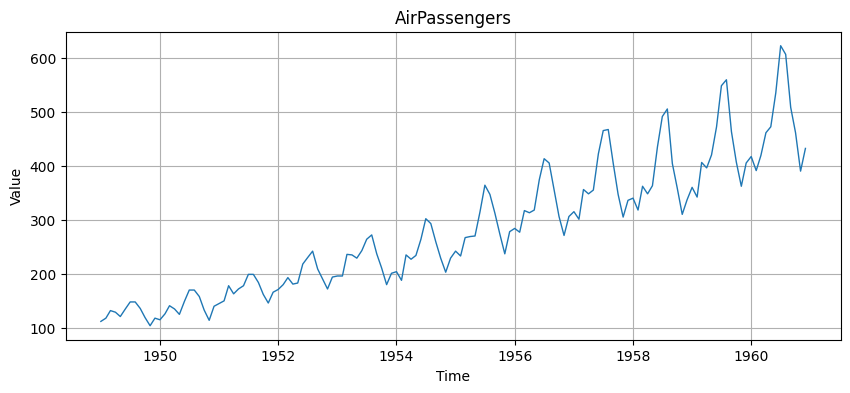

'c:\\Users\\nicol\\OneDrive\\Escritorio\\Tarea_2\\problema_2_forecasting\\figuras\\time_series_AirPassengers.png'

In [2]:
fn.plot_time_series(ts, title="AirPassengers")

In [3]:
from statsmodels.tsa.stattools import kpss
kps = kpss(ts, regression='c', nlags='auto')
kps

C:\Users\nicol\AppData\Local\Temp\ipykernel_21988\2989538325.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kps = kpss(ts, regression='c', nlags='auto')


(np.float64(1.6513122354165206),
 np.float64(0.01),
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [4]:
adf_res = fn.adf_check(ts)
adf_res

{'ADF Statistic': np.float64(0.8153688792060482),
 'p-value': np.float64(0.991880243437641),
 'lags used': 13,
 'n_obs': 130,
 'critical values': {'1%': np.float64(-3.4816817173418295),
  '5%': np.float64(-2.8840418343195267),
  '10%': np.float64(-2.578770059171598)}}

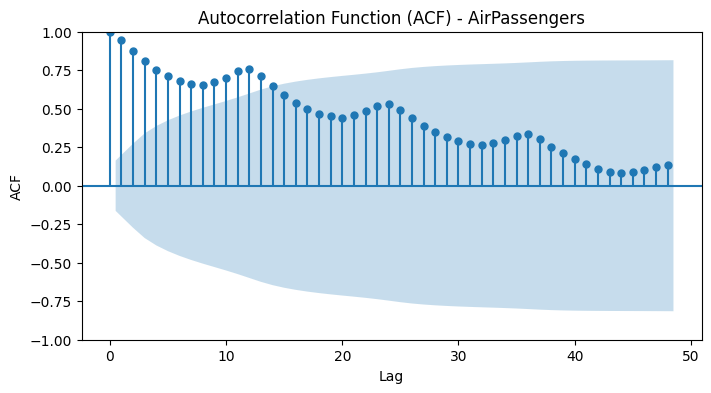

In [5]:
# Plot ACF
fig, ax = plt.subplots(figsize=(8,4))
plot_acf(ts, lags=48, ax=ax)

# Title and labels
ax.set_title("Autocorrelation Function (ACF) - AirPassengers")
ax.set_xlabel("Lag")
ax.set_ylabel("ACF")

# Save Figure
fig.savefig("acf_airpassengers.png", dpi=300, bbox_inches="tight")

# Show Figure
plt.show()


La prueba ADF arrojó un estadístico de 0.815, con un p‐valor de 0.99, el cual es muy superior a los niveles de significancia estándar (0.05–0.10).
Por lo tanto, no se rechaza la hipótesis nula de presencia de raíz unitaria y se concluye que la serie no es estacionaria, presentando tendencia y posiblemente componentes estacionales.

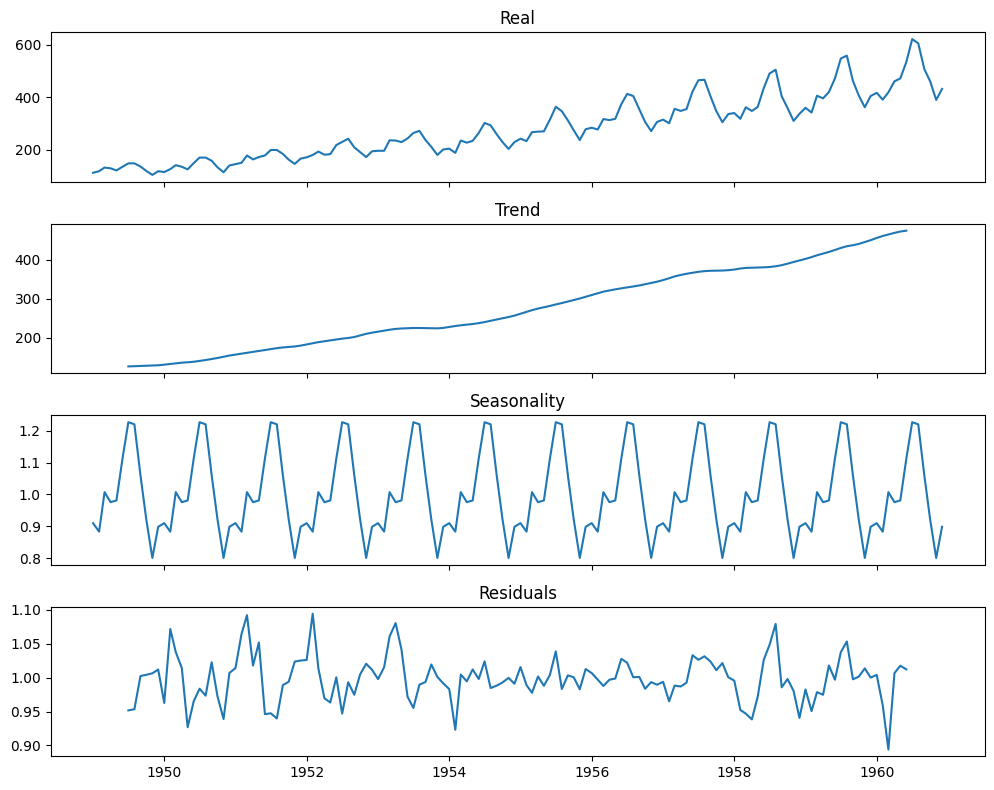

In [ ]:
decomp = seasonal_decompose(ts, model="multiplicative", period=12)

fig, axs = plt.subplots(4, 1, figsize=(10,8), sharex=True)

axs[0].plot(ts)
axs[0].set_title("Real")

axs[1].plot(decomp.trend)
axs[1].set_title("Trend")

axs[2].plot(decomp.seasonal)
axs[2].set_title("Seasonality")

axs[3].plot(decomp.resid)
axs[3].set_title("Residuals")

plt.tight_layout()
plt.savefig("decomp_multiplicative.png")
plt.show()


## ARIMA


In [7]:
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm

results = []

for p in range(6):
    try:
        model = sm.tsa.ARIMA(ts, order=(p,1,0))
        res = model.fit()
        results.append((p, res.aic))
    except:
        results.append((p, None))

for r in results:
    print(f"p={r[0]}, AIC={r[1]}")


p=0, AIC=1413.9091174789412
p=1, AIC=1401.8521274897143
p=2, AIC=1396.5876950339912
p=3, AIC=1395.020971664279
p=4, AIC=1388.216169549254
p=5, AIC=1390.1346321478718


In [8]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, name="series"):
    result = adfuller(series)
    print(f"\nADF Test for {name}:")
    print(f"  Statistic = {result[0]:.4f}")
    print(f"  p-value   = {result[1]:.4f}")
    print(f"  -> {'Stationary' if result[1]<0.05 else 'Not Stationary'}")

print("\n---- ORIGINAL ----")
check_stationarity(ts, "original")

print("\n---- 1st DIFFERENCE ----")
check_stationarity(ts.diff().dropna(), "d=1")

print("\n---- 2nd DIFFERENCE ----")
check_stationarity(ts.diff().diff().dropna(), "d=2")



---- ORIGINAL ----

ADF Test for original:
  Statistic = 0.8154
  p-value   = 0.9919
  -> Not Stationary

---- 1st DIFFERENCE ----

ADF Test for d=1:
  Statistic = -2.8293
  p-value   = 0.0542
  -> Not Stationary

---- 2nd DIFFERENCE ----

ADF Test for d=2:
  Statistic = -16.3842
  p-value   = 0.0000
  -> Stationary


In [9]:
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm

q_vals = range(0,13)
best = {"aic": 1e10, "order": None}

for q in q_vals:
    try:
        model = sm.tsa.ARIMA(ts, order=(4,2,q)).fit()
        print(f"q={q}, AIC={model.aic}")
        if model.aic < best["aic"]:
            best["aic"] = model.aic
            best["order"] = (4,2,q)
    except:
        pass

print(f"\nBest model so far: {best}")


q=0, AIC=1419.7059486321168
q=1, AIC=1385.2779225326835
q=2, AIC=1381.2952921107963
q=3, AIC=1376.4644923249375
q=4, AIC=1374.9701107864357
q=5, AIC=1363.684459117826
q=6, AIC=1359.9424501216342
q=7, AIC=1332.993756796182
q=8, AIC=1335.428439740698
q=9, AIC=1334.9593504065483
q=10, AIC=1333.7014793768228
q=11, AIC=1309.2834892132732
q=12, AIC=1316.1554730848436

Best model so far: {'aic': np.float64(1309.2834892132732), 'order': (4, 2, 11)}


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

train = ts.iloc[:-12]   
test  = ts.iloc[-12:]  

model = ARIMA(train, order=(4,2,3))
res = model.fit()

print(res.summary())
print("AIC =", res.aic)
print("BIC =", res.bic)
print("LogLikelihood =", res.llf)

forecast = res.forecast(steps=12)
forecast.index = test.index

def mae(y_true, y_pred): return np.mean(np.abs(y_true - y_pred))
def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred)**2))
def mape(y_true, y_pred): return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

print("\n--- FORECAST METRICS ---")
print("MAE :", mae(test, forecast))
print("RMSE:", rmse(test, forecast))
print("MAPE:", mape(test, forecast), "%")

fig, ax = plt.subplots(figsize=(10,5))
train.plot(ax=ax, label="Train")
test.plot(ax=ax, label="Test")
forecast.plot(ax=ax, label="ARIMA(4,2,11) Forecast", linestyle="--")
ax.set_title("ARIMA(4,2,11) Forecast vs Actual")
ax.legend()
fig.savefig("arima_4_2_11_forecast.png", dpi=300, bbox_inches="tight")
plt.close(fig)

resid = res.resid.dropna()

print("\n--- Residual Diagnostics (Ljung-Box) ---")
lb = acorr_ljungbox(resid, lags=[12, 24], return_df=True)
print(lb)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  132
Model:                 ARIMA(4, 2, 3)   Log Likelihood                -611.549
Date:                Fri, 05 Dec 2025   AIC                           1239.097
Time:                        20:18:48   BIC                           1262.037
Sample:                    01-01-1949   HQIC                          1248.419
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1382      0.093    -12.275      0.000      -1.320      -0.956
ar.L2         -0.3971      0.141     -2.823      0.005      -0.673      -0.121
ar.L3         -0.1324      0.141     -0.937      0.3

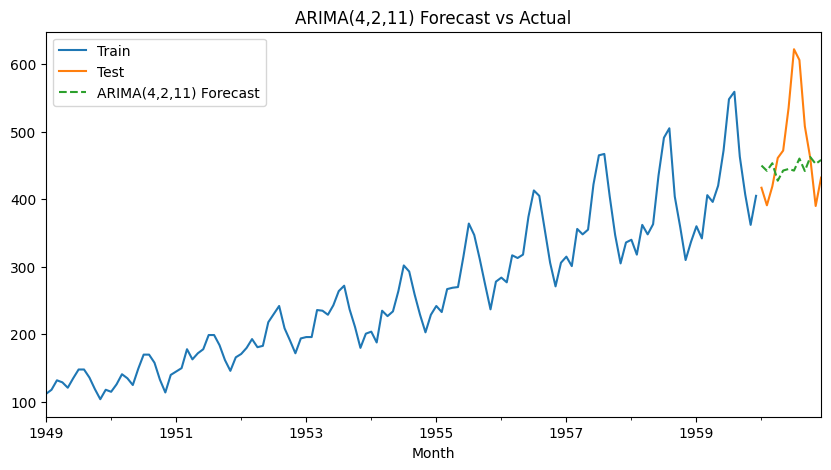

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
train.plot(ax=ax, label="Train")
test.plot(ax=ax, label="Test")
forecast.plot(ax=ax, label="ARIMA(4,2,11) Forecast", linestyle="--")
ax.set_title("ARIMA(4,2,11) Forecast vs Actual")
ax.legend()
fig.savefig("arima_4_2_11_forecast.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)


# SARIMA

In [ ]:
import warnings
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

p, d, q = 4, 2, 11

P = range(0, 3)  
D = range(0, 2) 
Q = range(0, 3)

seasonal_models = list(itertools.product(P, D, Q))

results = []

for (P_val, D_val, Q_val) in seasonal_models:
    try:
        model = SARIMAX(ts,
                        order=(p, d, q),
                        seasonal_order=(P_val, D_val, Q_val, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        results_fit = model.fit(disp=False)
        aic_val = results_fit.aic
        
        results.append({
            'P': P_val,
            'D': D_val,
            'Q': Q_val,
            'AIC': aic_val
        })
        
        print(f"(P={P_val}, D={D_val}, Q={Q_val}) AIC = {aic_val}")
        
    except Exception as e:
        print(f"(P={P_val}, D={D_val}, Q={Q_val}) failed: {e}")


results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='AIC')
results_df


(P=0, D=0, Q=0) AIC = 1240.26751111659
(P=0, D=0, Q=1) AIC = 1118.4741524502867
(P=0, D=0, Q=2) AIC = 1004.1348670640724
(P=0, D=1, Q=0) AIC = 940.504338505317
(P=0, D=1, Q=1) AIC = 853.4441629594571
(P=0, D=1, Q=2) AIC = 763.9924666516448
(P=1, D=0, Q=0) AIC = 1029.0622707320058
(P=1, D=0, Q=1) AIC = 1001.5449841864786
(P=1, D=0, Q=2) AIC = 852.6056335670594
(P=1, D=1, Q=0) AIC = 908.194975655661
(P=1, D=1, Q=1) AIC = 852.4846376691335
(P=1, D=1, Q=2) AIC = 765.3388885081025
(P=2, D=0, Q=0) AIC = 900.8378433395195
(P=2, D=0, Q=1) AIC = 912.681166171405
(P=2, D=0, Q=2) AIC = 908.5950255503666
(P=2, D=1, Q=0) AIC = 825.0690915388133
(P=2, D=1, Q=1) AIC = 825.7521394483095
(P=2, D=1, Q=2) AIC = 766.9078024702459


,P,D,Q,AIC
5,0,1,2,763.992467
11,1,1,2,765.338889
17,2,1,2,766.907802
15,2,1,0,825.069092
16,2,1,1,825.752139
10,1,1,1,852.484638
8,1,0,2,852.605634
4,0,1,1,853.444163
12,2,0,0,900.837843
9,1,1,0,908.194976


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

series = series.asfreq('MS')

model = SARIMAX(
    series,
    order=(4, 2, 11),
    seasonal_order=(0, 1, 2, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)

print(results.summary())


                                        SARIMAX Results                                         
Dep. Variable:                               Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 11)x(0, 1, [1, 2], 12)   Log Likelihood                -363.996
Date:                                  Fri, 05 Dec 2025   AIC                            763.992
Time:                                          20:19:47   BIC                            809.772
Sample:                                      01-01-1949   HQIC                           782.484
                                           - 12-01-1960                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1321      5.084     -0.223      0.824     -11.097

MAE = 20.43
RMSE = 25.31
MAPE = 4.60%


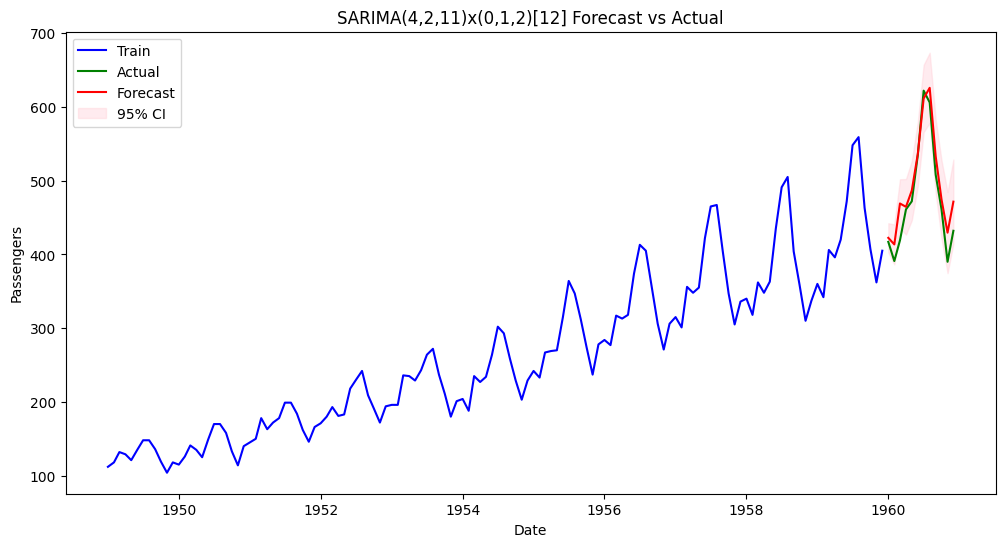

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

series = series.asfreq('MS')

train = series[:-12]
test = series[-12:]

model = SARIMAX(
    train,
    order=(4,2,11),
    seasonal_order=(0,1,2,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

mae = mean_absolute_error(test, forecast_mean)
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
mape = mean_absolute_percentage_error(test, forecast_mean) *100
print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")

plt.figure(figsize=(12,6))
plt.plot(train, label='Train', color='blue')
plt.plot(test, label='Actual', color='green')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='pink', alpha=0.3, label='95% CI'
)
plt.title('SARIMA(4,2,11)x(0,1,2)[12] Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()


# HOLT


Holt-Winters Forecast Metrics:
MAE  = 10.30
RMSE = 15.81
MAPE = 2.21%


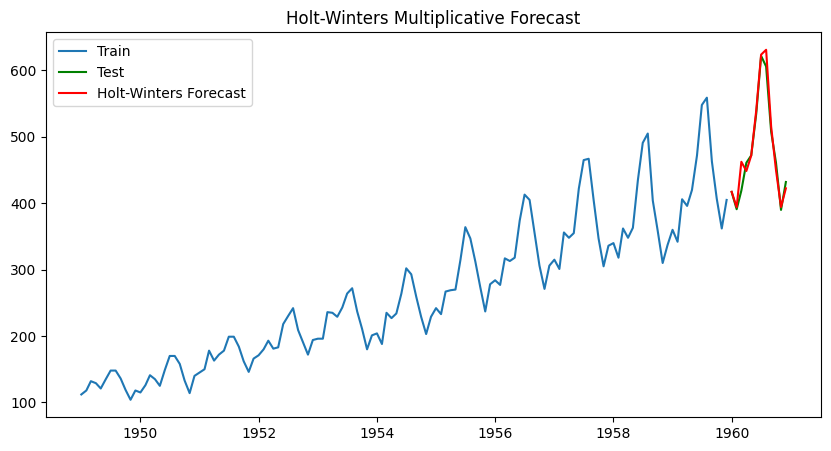

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

train = ts[:-12]  
test = ts[-12:]

hw_model = ExponentialSmoothing(
    train,
    trend='add',         
    seasonal='mul',     
    seasonal_periods=12
).fit(optimized=True)

hw_forecast = hw_model.forecast(12)

mae = mean_absolute_error(test, hw_forecast)
rmse = np.sqrt(mean_squared_error(test, hw_forecast))
mape = mean_absolute_percentage_error(test, hw_forecast)* 100   
print("Holt-Winters Forecast Metrics:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast', color='red')
plt.title("Holt-Winters Multiplicative Forecast")
plt.legend()
plt.show()


In [16]:
hw_model.params


{'smoothing_level': np.float64(0.37622239842195293),
 'smoothing_trend': np.float64(0.0),
 'smoothing_seasonal': np.float64(0.6237776015780471),
 'damping_trend': nan,
 'initial_level': np.float64(124.65407671290268),
 'initial_trend': np.float64(3.0182525792574806),
 'initial_seasons': array([0.87724549, 0.92352702, 1.01506971, 0.96501108, 0.8917954 ,
        0.97484713, 1.06085045, 1.04685691, 0.95447489, 0.83206697,
        0.7400465 , 0.85350414]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

## RANDOM FOREST


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

ts = series['Passengers']

def create_lag_features(series, n_lags=12):
    df = pd.DataFrame(series)
    for lag in range(1, n_lags+1):
        df[f'lag_{lag}'] = df['Passengers'].shift(lag)
    df['month'] = df.index.month  
    df = df.dropna()
    return df

df_lagged = create_lag_features(ts, n_lags=12)

train = df_lagged.iloc[:-12]
valid = df_lagged.iloc[-12:]

X_train = train.drop('Passengers', axis=1)
y_train = train['Passengers']
X_valid = valid.drop('Passengers', axis=1)
y_valid = valid['Passengers']

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_valid)

mae = mean_absolute_error(y_valid, y_pred)
rmse = mean_squared_error(y_valid, y_pred)
mape = mean_absolute_percentage_error(y_valid, y_pred) * 100

print(f"Random Forest Forecast Metrics:\nMAE  = {mae:.2f}\nRMSE = {rmse:.2f}\nMAPE = {mape:.2f}%")


Random Forest Forecast Metrics:
MAE  = 29.30
RMSE = 1431.11
MAPE = 5.94%


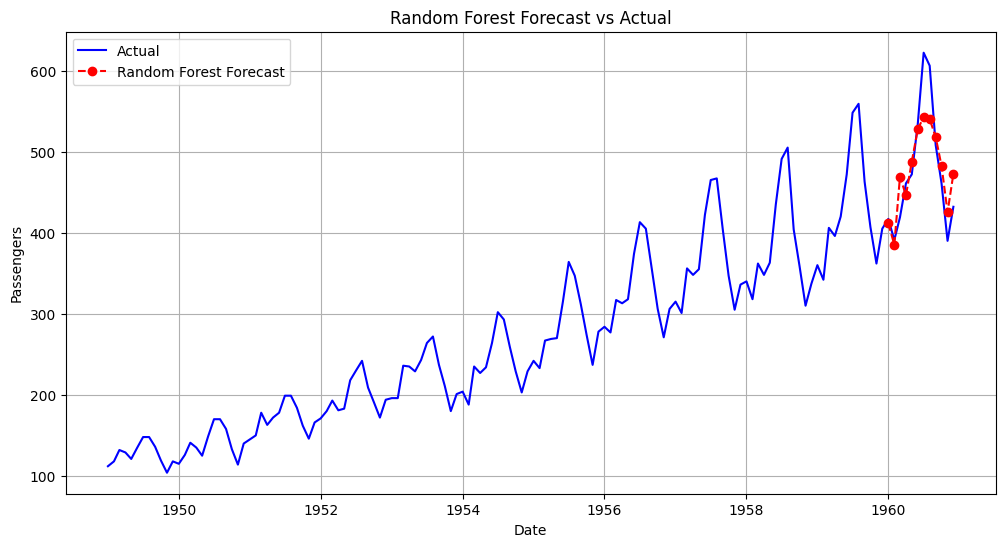

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(ts.index, ts.values, label='Actual', color='blue')
plt.plot(y_valid.index, y_pred, label='Random Forest Forecast', color='red', linestyle='--', marker='o')
plt.title('Random Forest Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()



=== ARIMA(1, 1, 1) ===
AIC: 1394.683
BIC: 1403.571
Log-Likelihood: -694.341


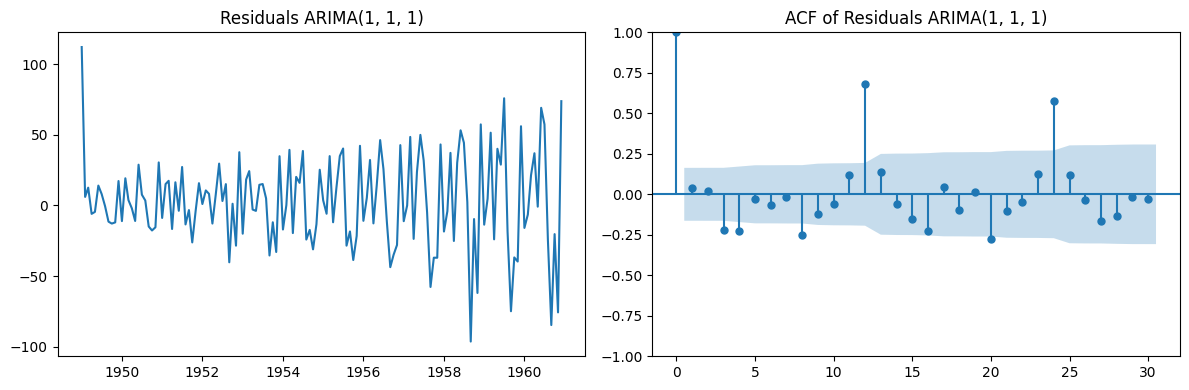

Mean of residuals: 2.7054109596486153
Standard deviation of residuals: 32.18091379755895

=== ARIMA(2, 1, 2) ===
AIC: 1353.347
BIC: 1368.161
Log-Likelihood: -671.673


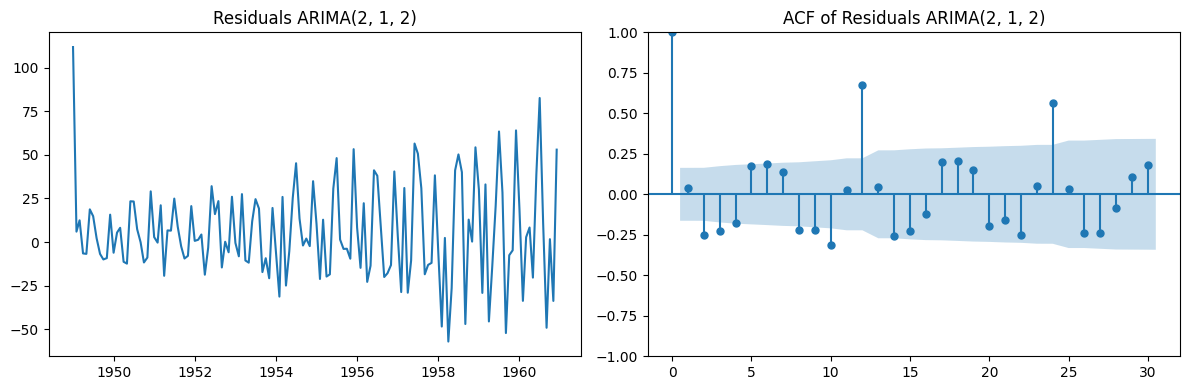

Mean of residuals: 5.6753070720802485
Standard deviation of residuals: 27.054219620366087

=== ARIMA(4, 1, 11) ===
AIC: 1303.055
BIC: 1350.461
Log-Likelihood: -635.528


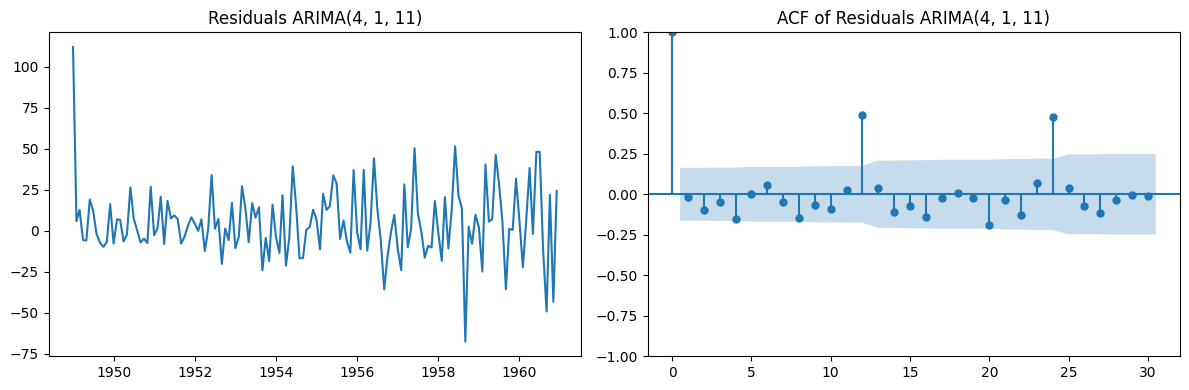

Mean of residuals: 4.85047054059532
Standard deviation of residuals: 21.41770200688805


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

param_configs = [(1, 1, 1), (2, 1, 2), (4, 1, 11)]  

results_dict = {}

for order in param_configs:
    print(f"\n=== ARIMA{order} ===")
    
    model = ARIMA(ts, order=order)
    result = model.fit()
    
    results_dict[order] = result
    
    print(f"AIC: {result.aic:.3f}")
    print(f"BIC: {result.bic:.3f}")
    print(f"Log-Likelihood: {result.llf:.3f}")
    
    residuals = result.resid
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(residuals)
    plt.title(f"Residuals ARIMA{order}")
    plt.subplot(1,2,2)
    plot_acf(residuals, lags=30, ax=plt.gca())
    plt.title(f"ACF of Residuals ARIMA{order}")
    plt.tight_layout()
    plt.show()
    
    print("Mean of residuals:", np.mean(residuals))
    print("Standard deviation of residuals:", np.std(residuals))


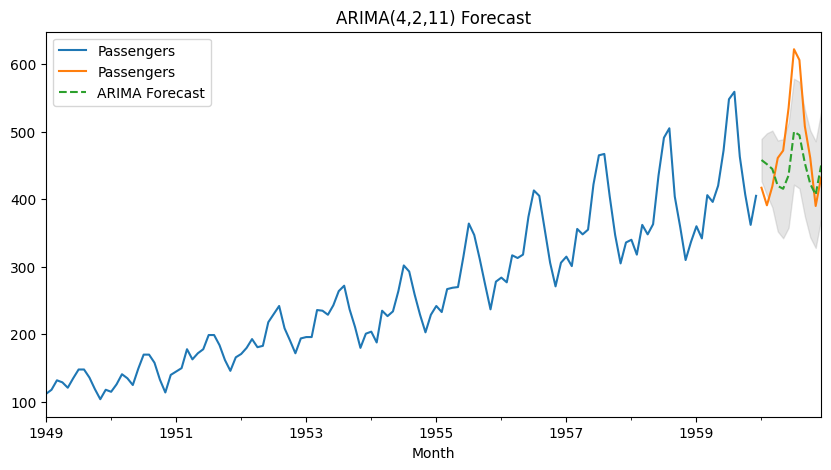

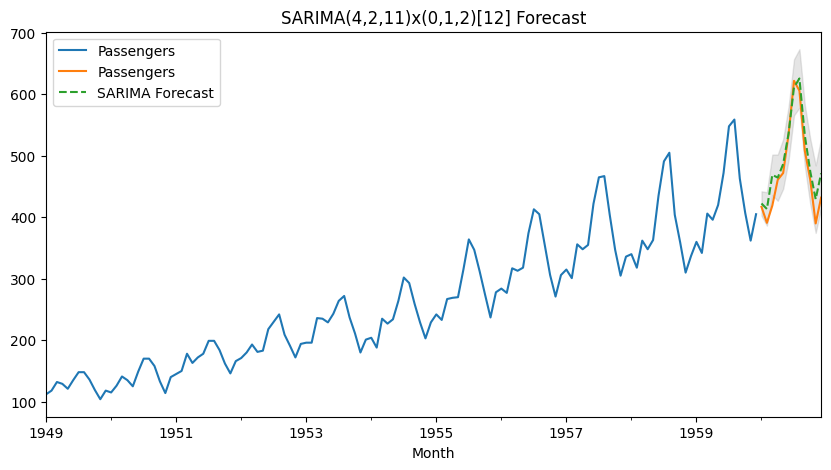

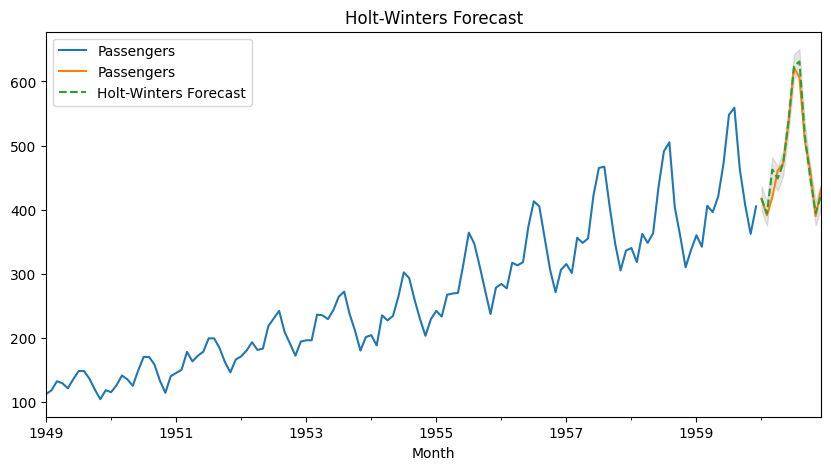

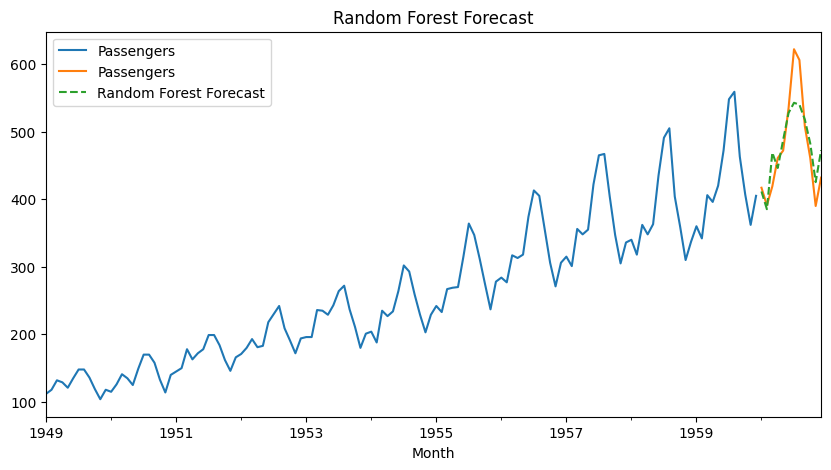

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor

train = series.iloc[:-12]
test  = series.iloc[-12:]

arima_model = ARIMA(train, order=(4,2,11))
arima_res = arima_model.fit()
arima_forecast = arima_res.get_forecast(steps=12)
arima_mean = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int()

fig, ax = plt.subplots(figsize=(10,5))
train.plot(ax=ax, label='Train')
test.plot(ax=ax, label='Test')
arima_mean.plot(ax=ax, label='ARIMA Forecast', linestyle='--')
ax.fill_between(arima_ci.index, arima_ci.iloc[:,0], arima_ci.iloc[:,1], color='gray', alpha=0.2)
ax.set_title('ARIMA(4,2,11) Forecast')
ax.legend()
plt.show()


sarima_model = SARIMAX(train, order=(4,2,11), seasonal_order=(0,1,2,12),
                       enforce_stationarity=False, enforce_invertibility=False)
sarima_res = sarima_model.fit(disp=False)
sarima_forecast = sarima_res.get_forecast(steps=12)
sarima_mean = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

fig, ax = plt.subplots(figsize=(10,5))
train.plot(ax=ax, label='Train')
test.plot(ax=ax, label='Test')
sarima_mean.plot(ax=ax, label='SARIMA Forecast', linestyle='--')
ax.fill_between(sarima_ci.index, sarima_ci.iloc[:,0], sarima_ci.iloc[:,1], color='gray', alpha=0.2)
ax.set_title('SARIMA(4,2,11)x(0,1,2)[12] Forecast')
ax.legend()
plt.show()


hw_model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12)
hw_res = hw_model.fit(optimized=True)
hw_forecast = hw_res.forecast(12)
hw_std = np.std(hw_res.resid)
hw_upper = hw_forecast + 1.96*hw_std
hw_lower = hw_forecast - 1.96*hw_std

fig, ax = plt.subplots(figsize=(10,5))
train.plot(ax=ax, label='Train')
test.plot(ax=ax, label='Test')
hw_forecast.plot(ax=ax, label='Holt-Winters Forecast', linestyle='--')
ax.fill_between(hw_forecast.index, hw_lower, hw_upper, color='gray', alpha=0.2)
ax.set_title('Holt-Winters Forecast')
ax.legend()
plt.show()


def create_lag_features(series, n_lags=12):
    df = pd.DataFrame(series)
    for lag in range(1, n_lags+1):
        df[f'lag_{lag}'] = df.iloc[:,0].shift(lag)
    df['month'] = df.index.month
    df = df.dropna()
    return df

df_lagged = create_lag_features(series, n_lags=12)
train_rf = df_lagged.iloc[:-12]
test_rf  = df_lagged.iloc[-12:]

X_train = train_rf.drop(train_rf.columns[0], axis=1)
y_train = train_rf.iloc[:,0]
X_test  = test_rf.drop(test_rf.columns[0], axis=1)
y_test  = test_rf.iloc[:,0]

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_pred = pd.Series(rf.predict(X_test), index=test.index)

fig, ax = plt.subplots(figsize=(10,5))
train.plot(ax=ax, label='Train')
test.plot(ax=ax, label='Test')
rf_pred.plot(ax=ax, label='Random Forest Forecast', linestyle='--')
ax.set_title('Random Forest Forecast')
ax.legend()
plt.show()


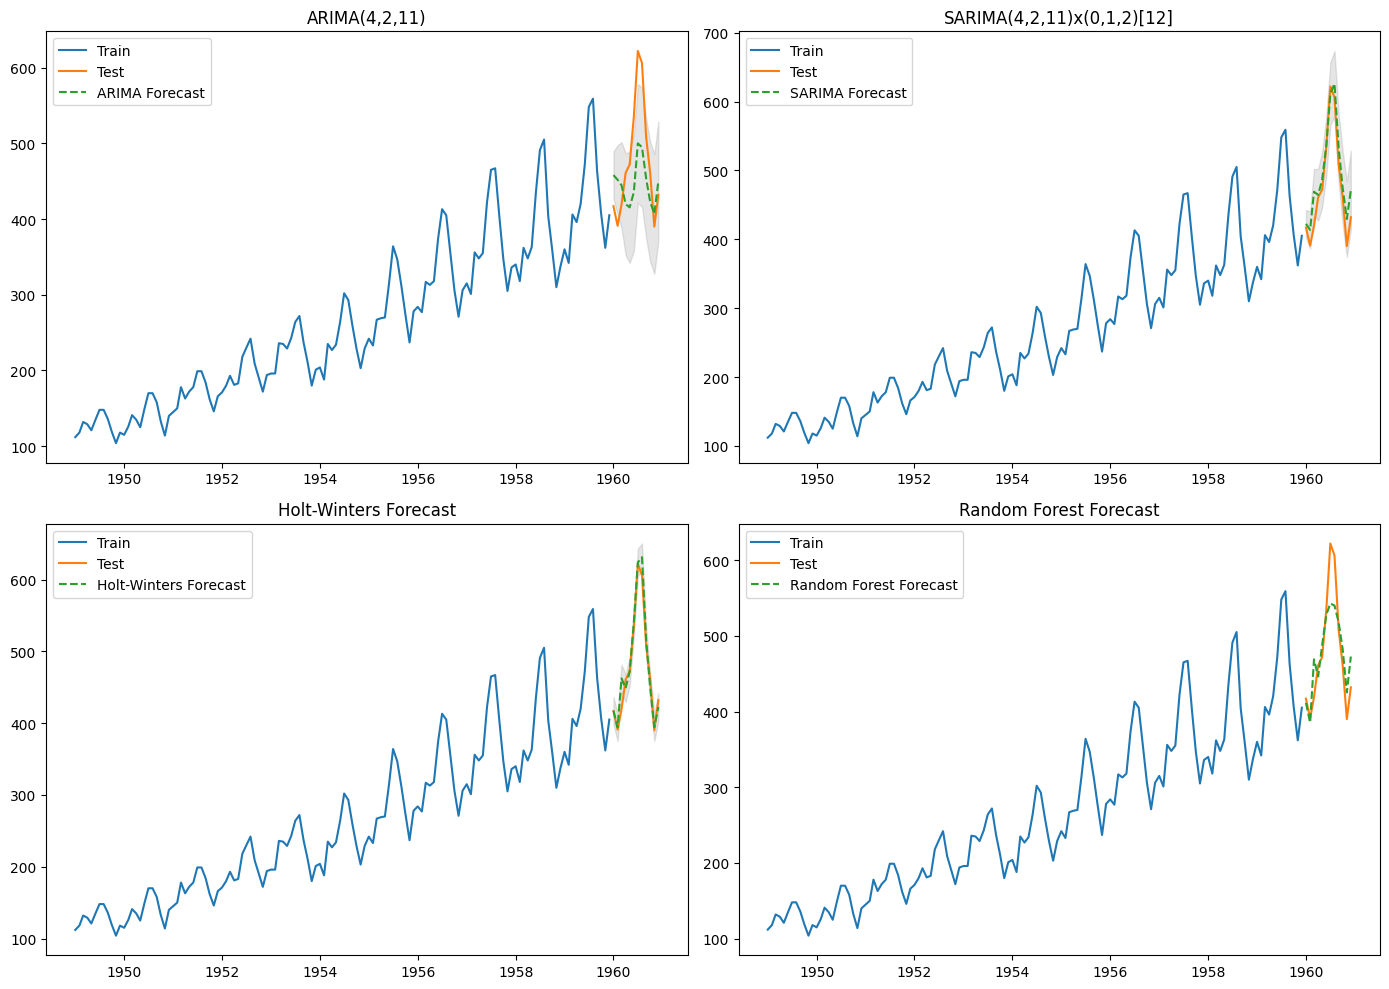

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14,10))

axes[0,0].plot(train.index, train, label='Train')
axes[0,0].plot(test.index, test, label='Test')
axes[0,0].plot(arima_mean.index, arima_mean, linestyle='--', label='ARIMA Forecast')
axes[0,0].fill_between(arima_ci.index, arima_ci.iloc[:,0], arima_ci.iloc[:,1], color='gray', alpha=0.2)
axes[0,0].set_title('ARIMA(4,2,11)')
axes[0,0].legend()


axes[0,1].plot(train.index, train, label='Train')
axes[0,1].plot(test.index, test, label='Test')
axes[0,1].plot(sarima_mean.index, sarima_mean, linestyle='--', label='SARIMA Forecast')
axes[0,1].fill_between(sarima_ci.index, sarima_ci.iloc[:,0], sarima_ci.iloc[:,1], color='gray', alpha=0.2)
axes[0,1].set_title('SARIMA(4,2,11)x(0,1,2)[12]')
axes[0,1].legend()


axes[1,0].plot(train.index, train, label='Train')
axes[1,0].plot(test.index, test, label='Test')
axes[1,0].plot(hw_forecast.index, hw_forecast, linestyle='--', label='Holt-Winters Forecast')
axes[1,0].fill_between(hw_forecast.index, hw_lower, hw_upper, color='gray', alpha=0.2)
axes[1,0].set_title('Holt-Winters Forecast')
axes[1,0].legend()


axes[1,1].plot(train.index, train, label='Train')
axes[1,1].plot(test.index, test, label='Test')
axes[1,1].plot(rf_pred.index, rf_pred, linestyle='--', label='Random Forest Forecast')
axes[1,1].set_title('Random Forest Forecast')
axes[1,1].legend()

plt.tight_layout()
plt.show()


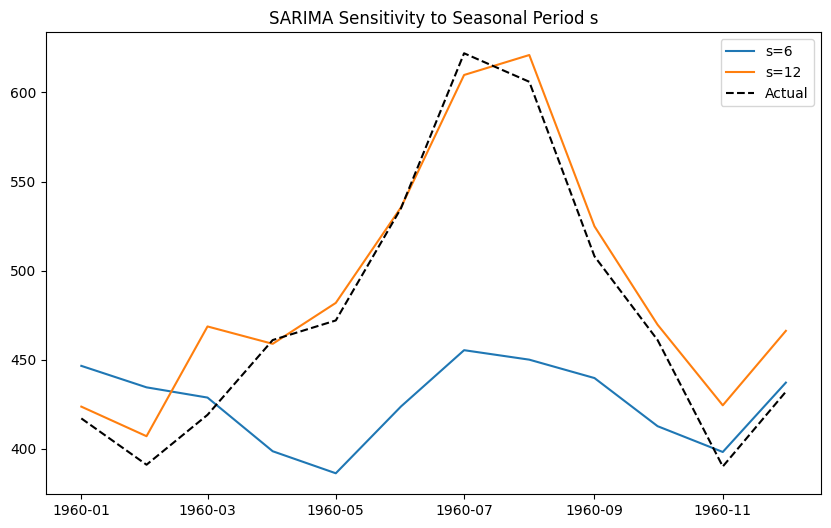

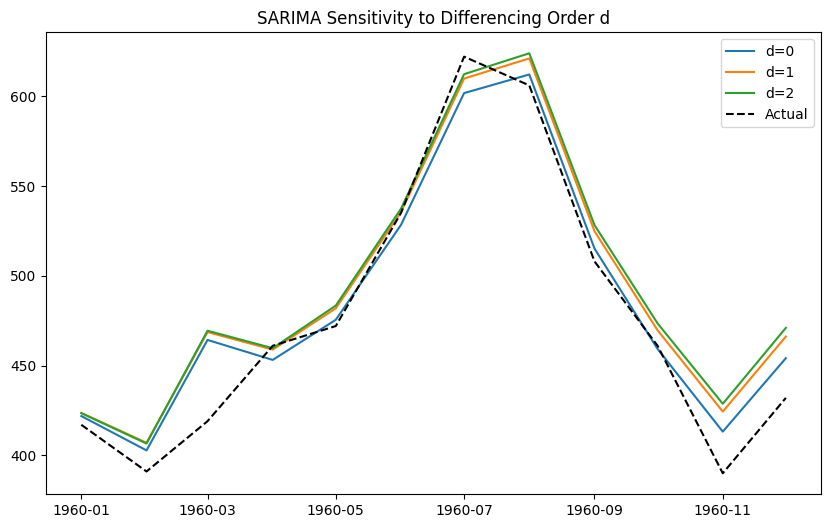

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd


train = series.iloc[:-12]
test  = series.iloc[-12:]


seasonals = [6, 12]
plt.figure(figsize=(10,6))

for s in seasonals:
    model = SARIMAX(train, order=(1,1,1), seasonal_order=(0,1,1,s),
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    forecast = res.get_forecast(steps=12).predicted_mean
    plt.plot(forecast.index, forecast, label=f's={s}')

plt.plot(test.index, test, label='Actual', color='black', linestyle='--')
plt.title("SARIMA Sensitivity to Seasonal Period s")
plt.legend()
plt.show()


diff_orders = [0, 1, 2]  
plt.figure(figsize=(10,6))

for d in diff_orders:
    model = SARIMAX(train, order=(1,d,1), seasonal_order=(0,1,1,12),
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    forecast = res.get_forecast(steps=12).predicted_mean
    plt.plot(forecast.index, forecast, label=f'd={d}')

plt.plot(test.index, test, label='Actual', color='black', linestyle='--')
plt.title("SARIMA Sensitivity to Differencing Order d")
plt.legend()
plt.show()
